In [1]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=12000)])
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

from tensorflow import keras
from tifffile import imsave, imread, imwrite
from keras.models import Input, Model
from keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau,LearningRateScheduler
from tifffile import imwrite, imread

from datagenerator_2D import data_generator
from model_2D_interconnect import make_generator
# from Model_2D_Unet import make_generator
# from Model_2D_RCAN import make_generator
from loss_2D import generator_loss

1 Physical GPUs, 1 Logical GPUs


In [2]:
GT_image_dr =r'D:\Projects\Denoising-STED\20220913-RPI\3D STED\low SNR\2.tif'
lowSNR_image_dr =r'D:\Projects\Denoising-STED\20220913-RPI\3D STED\low SNR\1m.tif'

lp = 0.5
gam = 1.2

model_save_directory_2 =  r"D:\Projects\Denoising-STED\20220913-RPI\mitochondria\modfied_histogram\mitochondria_Unet-rcan.h5"
model_save_directory_r = r"D:\Projects\Denoising-STED\20220913-RPI\comparison with other models\RCAN\Mitochondria\mitochondria_rcan.h5"

save_parameters_dr_2 = r"D:\Projects\Denoising-STED\20220913-RPI\cristae\cristae_lamb_0.1.csv"
save_parameters_dr_r = r"D:\Projects\Denoising-STED\20220913-RPI\UNet-RCAN-different psnr\param_rcan_psnr5.0.csv"

save_image_dr = r"D:\Projects\Denoising-STED\membrane\results\synthetic" 



In [3]:
# GT_image_dr = r'D:\Projects\Denoising-STED\20220913-RPI\mitochondria\test\Average.tif'
# lowSNR_image_dr =r'D:\Projects\Denoising-STED\20220913-RPI\mitochondria\test\1frame.tif'

# GT_image_dr = r'D:\Projects\Denoising-STED\20220913-RPI\tubulin-clathrine\test\Average.tif'
# lowSNR_image_dr =r'D:\Projects\Denoising-STED\20220913-RPI\tubulin-clathrine\test\1frame.tif'

# GT_image_dr = r'D:\Projects\Denoising-STED\20220913-RPI\histone\test\Average.tif'
# lowSNR_image_dr =r'D:\Projects\Denoising-STED\20220913-RPI\histone\test\1frame.tif'



patch_size =2048
n_patches = 1
n_channel =  0
add_noise =False
lp = 0.1

x_test, y_test,_,_ = data_generator(GT_image_dr, lowSNR_image_dr, patch_size, n_patches,
                                                    n_channel, threshold =0 ,ratio=1.0,lp=lp, augment=False, shuffle=False,
                                   add_noise=add_noise)

(64, 1, 2048, 2048)
64
The training set shape is: (64, 2048, 2048, 1)
The validation set shape is: (0, 2048, 2048, 1)


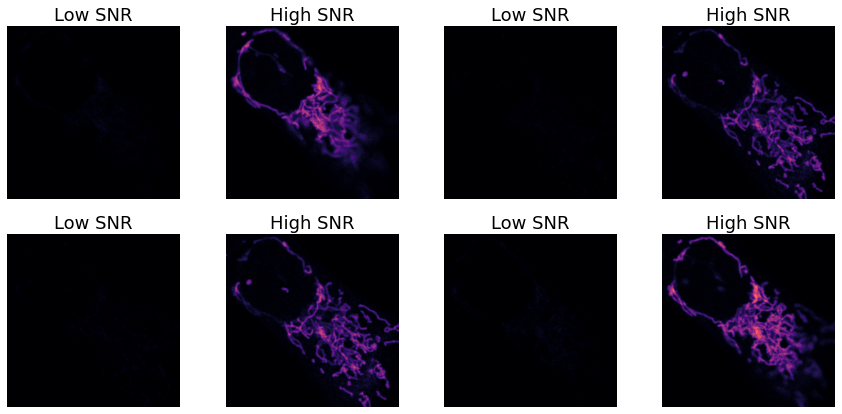

In [4]:
ix = np.random.randint(0,len(x_test),4)
fig = plt.figure(figsize=(15,7))

for i in range(4):
    fig.add_subplot(2,4, 2*i+1)
    cmap=plt.get_cmap('magma')
    plt.imshow(x_test[ix[i],:,:,0].squeeze(),cmap)
    plt.title('Low SNR',fontdict={'fontsize':18})
    plt_axis = plt.axis('off')

    fig.add_subplot(2,4, 2*i+2)
    cmap=plt.get_cmap('magma')
    plt.imshow(y_test[ix[i],:,:,0].squeeze(),cmap)
    plt.title('High SNR',fontdict={'fontsize':18})
    plt_axis = plt.axis('off')

In [5]:
# model_save_directory = r"D:\Projects\Denoising-STED\20220913-RPI\UNet-RCAN-different psnr\mitochondria_2step_psnr0.5.h5" 
# model_save_directory = r"D:\Projects\Denoising-STED\20220913-RPI\comparison twostep-onestep-rcan\tubulin_2step.h5" 
# model_save_directory = r"D:\Projects\Denoising-STED\20220913-RPI\tubulin-clathrine\clathrine\clathrine_2step_1.h5" 
# model_save_directory = r"D:\Projects\Denoising-STED\20220913-RPI\tubulin-histone\histon_2step.h5" 



filters =[32,64,128]
# filters =[80,160,320]
num_filters = filters[0]
# filters_cab=num_filters/8
filters_cab=num_filters/16

num_RG=3
num_RCAB=8

generator_input = Input((patch_size, patch_size,1))
generator = make_generator(generator_input, filters, num_filters,filters_cab,num_RG,num_RCAB,
                           kernel_shape=3,dropout=0.2)
generator.load_weights(model_save_directory_2)

prediction1 = np.zeros(x_test.shape)
prediction2 = np.zeros(x_test.shape)

for i in range(len(x_test)):
    prediction1[i],prediction2[i]= generator(x_test[i:i+1],training=False)
#     prediction2[i] = generator(x_test[i:i+1],training=False)
#     prediction1[i] = prediction1[i]/prediction1[i].max()
#     prediction2[i] = prediction2[i]/prediction2[i].max()
prediction1 = prediction1/prediction1.max()
prediction2= prediction2/prediction2.max()
prediction1[prediction1<0]=0
prediction2[prediction2<0]=0

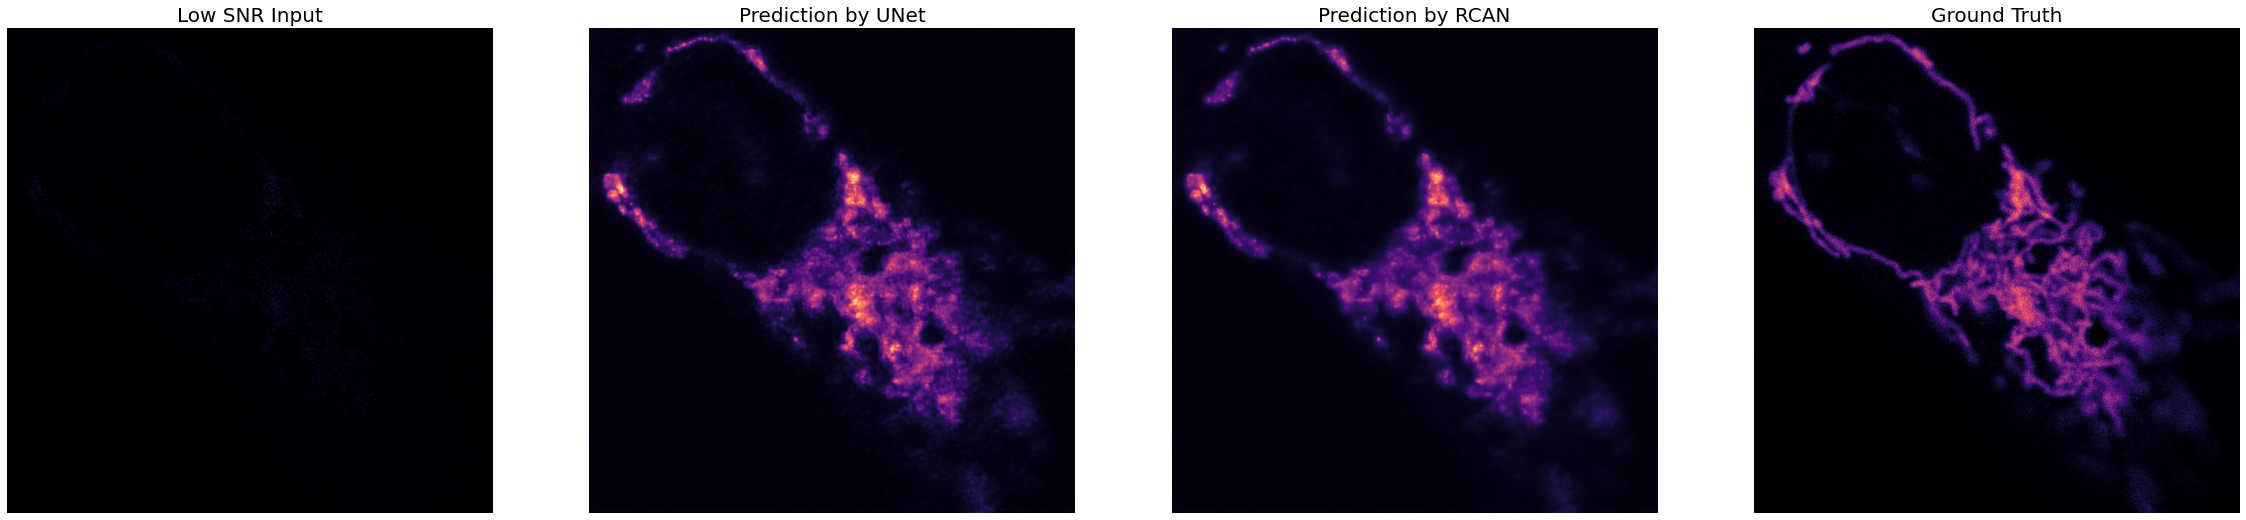

In [7]:
ix = np.random.randint(len(prediction1))
# ix = 0
fig = plt.figure(figsize=(40,40))

plt.subplot(1, 4, 1)
plt.imshow(x_test[ix, :, :, 0] , cmap='magma')
plt.title('Low SNR Input',fontdict={'fontsize':20})
plt_axis = plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(prediction1[ix, :, :, 0] , cmap='magma')
plt.title('Prediction by UNet',fontdict={'fontsize':20})
plt_axis = plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(prediction2[ix, :, :, 0] , cmap='magma')
plt.title('Prediction by RCAN',fontdict={'fontsize':20})
plt_axis = plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(y_test[ix, :, :, 0] , cmap='magma')
plt.title('Ground Truth',fontdict={'fontsize':20})
plt_axis = plt.axis('off')

In [8]:
save_image_dr = r"D:\Projects\Denoising-STED\20220913-RPI\3D STED" 

# pred1_test = np.moveaxis(prediction1,3,1)
# pred2_test = np.moveaxis(prediction2,3,1)
# X_test = np.moveaxis(x_test,3,1)
# Y_test = np.moveaxis(y_test,3,1)


pred1_test = prediction1*(2**16-1)
pred2_test = prediction2*(2**16-1)
X_test = x_test*(2**16-1)
Y_test = y_test*(2**16-1)

pred1_test = pred1_test.astype(np.uint16)
pred2_test = pred2_test.astype(np.uint16)

X_test = X_test.astype(np.uint16)
Y_test = Y_test.astype(np.uint16)

# imwrite(save_image_dr+'/pred1.tif', pred1_test.squeeze(),imagej=True,metadata={'axes': 'TYX'})
imwrite(save_image_dr+'/pred2_unetrcan.tif', pred2_test.squeeze(),imagej=True,metadata={'axes': 'TYX'})

# imwrite(save_image_dr+'/noisy.tif', X_test.squeeze(),imagej=True,metadata={'axes': 'TYX'})
# imwrite(save_image_dr+'/gt.tif', Y_test.squeeze(),imagej=True,metadata={'axes': 'TYX'})

In [ ]:
prediction2 = prediction2**(gam)
for i in range(len(prediction2)):
    prediction2[i] = prediction2[i]/prediction2[i].max()
    
prediction1 = prediction1**(gam)
for i in range(len(prediction1)):
    prediction1[i] = prediction1[i]/prediction1[i].max()

In [ ]:
# save_parameters_dr = r"D:\Projects\Denoising-STED\20220913-RPI\UNet-RCAN-different psnr\lambda 0.5\param_2step.csv"

def norm_mse(prediction, gt):
    mse = tf.keras.metrics.mean_squared_error(prediction, gt)
    mse = tf.math.reduce_sum(mse, axis=(1, 2))
    norm = tf.norm(gt, axis=(1, 2))
    norm = tf.squeeze(norm)
    norm = tf.pow(norm, 2)
    norm = tf.math.reduce_sum(norm)
    norm_mse = tf.math.divide(mse, norm)
    return norm_mse.numpy()

def nmse_psnr_ssim(prediction,gt):
    nmse = norm_mse(prediction,gt)
    psnr = tf.image.psnr(prediction, gt, max_val = 1.0).numpy()
    ssim = tf.image.ssim_multiscale(prediction, gt, max_val = 1.0, filter_size=14,
                                    filter_sigma=1.5, k1=0.01, k2=0.03).numpy()
    return nmse,psnr,ssim
    
imageq_param = np.zeros((9,len(prediction1)))

imageq_param[0::3,:] = nmse_psnr_ssim(x_test,y_test)
imageq_param[1::3,:] = nmse_psnr_ssim(prediction1,y_test)
imageq_param[2::3,:] = nmse_psnr_ssim(prediction2,y_test)


fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
labels = ['noisy', 'prediction1', 'prediction2']

bplot1 = axes[0].boxplot([imageq_param[0,:],imageq_param[1,:],imageq_param[2,:]],
                         vert=True,  
                         patch_artist=True,  
                         labels=labels,showfliers=False)  
axes[0].set_title('NMSE',fontsize=20)

bplot2 = axes[1].boxplot([imageq_param[3,:],imageq_param[4,:],imageq_param[5,:]],
                         vert=True,  
                         patch_artist=True,  
                         labels=labels,showfliers=False)  
axes[1].set_title('PSNR',fontsize=20)

bplot3 = axes[2].boxplot([imageq_param[6,:],imageq_param[7,:],imageq_param[8,:]],
                         vert=True,  
                         patch_artist=True,  
                         labels=labels,showfliers=False)  
cc= axes[2].set_title('MS-SSIM',fontsize=20)


# np.savetxt(save_parameters_dr_2, np.transpose(imageq_param), delimiter=",")

In [ ]:
from Model_2D_RCAN import make_generator

filters =[64,128,256]
num_filters = filters[0]
filters_cab=num_filters/8
num_RG=3
num_RCAB=8

generator_input = Input((patch_size, patch_size,1))
generator = make_generator(generator_input, filters, num_filters,filters_cab,num_RG,num_RCAB,
                           kernel_shape=3,dropout=0.2)
generator.load_weights(model_save_directory_r)

prediction1 = np.zeros(x_test.shape)
prediction2 = np.zeros(x_test.shape)

for i in range(len(x_test)):
    prediction2[i] = generator(x_test[i:i+1],training=False)
    prediction2[i] = prediction2[i]/prediction2[i].max()
# prediction1 = prediction1/prediction1.max()
# prediction2= prediction2/prediction2.max()
prediction1[prediction1<0]=0
prediction2[prediction2<0]=0

In [ ]:
prediction2 = prediction2**(gam)
for i in range(len(prediction2)):
    prediction2[i] = prediction2[i]/prediction2[i].max()

In [ ]:
ix = np.random.randint(len(prediction1))
# ix = 0
fig = plt.figure(figsize=(40,40))

plt.subplot(1, 4, 1)
plt.imshow(x_test[ix, :, :, 0] , cmap='magma')
plt.title('Low SNR Input',fontdict={'fontsize':20})
plt_axis = plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(prediction1[ix, :, :, 0] , cmap='magma')
plt.title('Prediction by UNet',fontdict={'fontsize':20})
plt_axis = plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(prediction2[ix, :, :, 0] , cmap='magma')
plt.title('Prediction by RCAN',fontdict={'fontsize':20})
plt_axis = plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(y_test[ix, :, :, 0] , cmap='magma')
plt.title('Ground Truth',fontdict={'fontsize':20})
plt_axis = plt.axis('off')

In [ ]:
def norm_mse(prediction, gt):
    mse = tf.keras.metrics.mean_squared_error(prediction, gt)
    mse = tf.math.reduce_sum(mse, axis=(1, 2))
    norm = tf.norm(gt, axis=(1, 2))
    norm = tf.squeeze(norm)
    norm = tf.pow(norm, 2)
    norm = tf.math.reduce_sum(norm)
    norm_mse = tf.math.divide(mse, norm)
    return norm_mse.numpy()

def nmse_psnr_ssim(prediction,gt):
    nmse = norm_mse(prediction,gt)
    psnr = tf.image.psnr(prediction, gt, max_val = 1.0).numpy()
    ssim = tf.image.ssim_multiscale(prediction, gt, max_val = 1.0, filter_size=14,
                                    filter_sigma=1.5, k1=0.01, k2=0.03).numpy()
    return nmse,psnr,ssim
    
imageq_param = np.zeros((6,len(prediction1)))

imageq_param[0::2,:] = nmse_psnr_ssim(x_test,y_test)
imageq_param[1::2,:] = nmse_psnr_ssim(prediction2,y_test)


fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
labels = ['noisy', 'prediction2']

bplot1 = axes[0].boxplot([imageq_param[0,:],imageq_param[1,:]],
                         vert=True,  
                         patch_artist=True,  
                         labels=labels,showfliers=False)  
axes[0].set_title('NMSE',fontsize=20)

bplot2 = axes[1].boxplot([imageq_param[2,:],imageq_param[3,:]],
                         vert=True,  
                         patch_artist=True,  
                         labels=labels,showfliers=False)  
axes[1].set_title('PSNR',fontsize=20)

bplot3 = axes[2].boxplot([imageq_param[4,:],imageq_param[5,:]],
                         vert=True,  
                         patch_artist=True,  
                         labels=labels,showfliers=False)  
cc= axes[2].set_title('MS-SSIM',fontsize=20)


# np.savetxt(save_parameters_dr_r, np.transpose(imageq_param), delimiter=",")

In [ ]:
# save_image_dr = r"D:\Projects\Denoising-STED\20220913-RPI\UNet-RCAN-different psnr\lambda 0.01" 

# pred1_test = np.moveaxis(prediction1,3,1)
# pred2_test = np.moveaxis(prediction2,3,1)
# X_test = np.moveaxis(x_test,3,1)
# Y_test = np.moveaxis(y_test,3,1)


pred1_test = prediction1*(2**16-1)
pred2_test = prediction2*(2**16-1)
X_test = x_test*(2**16-1)
Y_test = y_test*(2**16-1)

pred1_test = pred1_test.astype(np.uint16)
pred2_test = pred2_test.astype(np.uint16)

X_test = X_test.astype(np.uint16)
Y_test = Y_test.astype(np.uint16)

imwrite(save_image_dr+'/pred_rcan_lp'+str(lp)+'.tif', pred2_test.squeeze(),imagej=True,metadata={'axes': 'TYX'})